In [5]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy.io import wavfile
import numpy as np
import seaborn as sns
from scipy.spatial import distance
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, InputLayer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from random import randrange
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model 
import tensorflow.keras.utils as ku 
import keras.backend as K
import tensorflow as tf
from sklearn.model_selection import train_test_split
import IPython.display as ipd



In [ ]:
##################
# Verifications:
#################
print('GPU is used.' if len(tf.config.list_physical_devices('GPU')) > 0 else 'GPU is NOT used.')
print("Tensorflow version: " + tf.__version__)

GPU is used.
Tensorflow version: 2.6.0


In [1]:
#!wget http://206.12.93.90:8080/LJSpeech-1.1/LJSpeech-1.1.tar.gz
#!tar -xzvf  LJSpeech-1.1.tar.gz 2> /dev/null
#!rm LJSpeech-1.1.tar.gz
 

In [ ]:
folder = "LJSpeech-1.1/wavs/"

# Parameters

In [ ]:
nperseg = 256
#max len of output sequences
maxlen = 100

#Hidden units of LSTM
hidden_dim = 64

#Batch size
bs = 64

#Number of epochs
no_epochs = 30

# Visualisation

In [ ]:
def visualisation(file):
    sample_rate, samples = wavfile.read(file)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate, nperseg=nperseg)
    spectrogram = np.transpose(spectrogram)
    print('Sample rate :', sample_rate)
    print('Samples: ', len(samples))
    print('Frequencies: ', len(frequencies))
    print('Times:', len(times))

    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot(2,1,1)
    plt.title("Signal Wave...")
    plt.plot(samples)

    ax = plt.subplot(2,1,2)
    im = ax.imshow(np.transpose(spectrogram), vmax=100)
    #plt.title('Pearson correlation')
    plt.xlabel('Time step')
    plt.ylabel('Frequencies')
    divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #fig.colorbar(im, cax = cax)
    plt.show()

In [ ]:
#Play an audio (LJ050-0222.wav)
ipd.Audio(folder + "LJ050-0222.wav")

File name: LJ050-0222.wav
Transcription: 'would take approximately 20 months to implement and require expenditures of approximately $3,000,000 during that period.'
Sample rate : 22050
Samples:  173981
Frequencies:  129
Times: 776


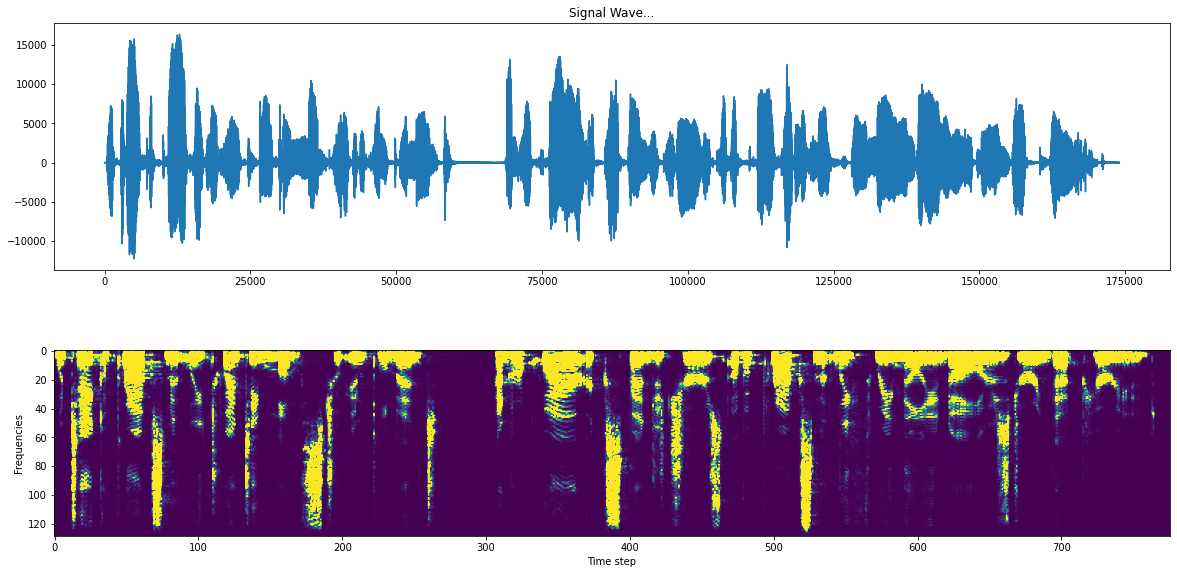

--------------------------------------------------


In [ ]:
df = pd.read_csv('LJSpeech-1.1/metadata.csv', sep='|', header=None)
print("File name: LJ050-0222.wav")
print(f"Transcription: '{df[df[0] == 'LJ050-0222'][1].values[0]}'")
visualisation(folder + 'LJ050-0222.wav')
print('-'*50)

In [ ]:
#Play an audio (LJ050-0223.wav)
ipd.Audio(folder + "LJ050-0223.wav")

File name: LJ050-0223.wav
Transcription: 'The plan provides for an additional 205 agents for the Secret Service. Seventeen of this number are proposed for the Protective Research Section;'
Sample rate : 22050
Samples:  210589
Frequencies:  129
Times: 939


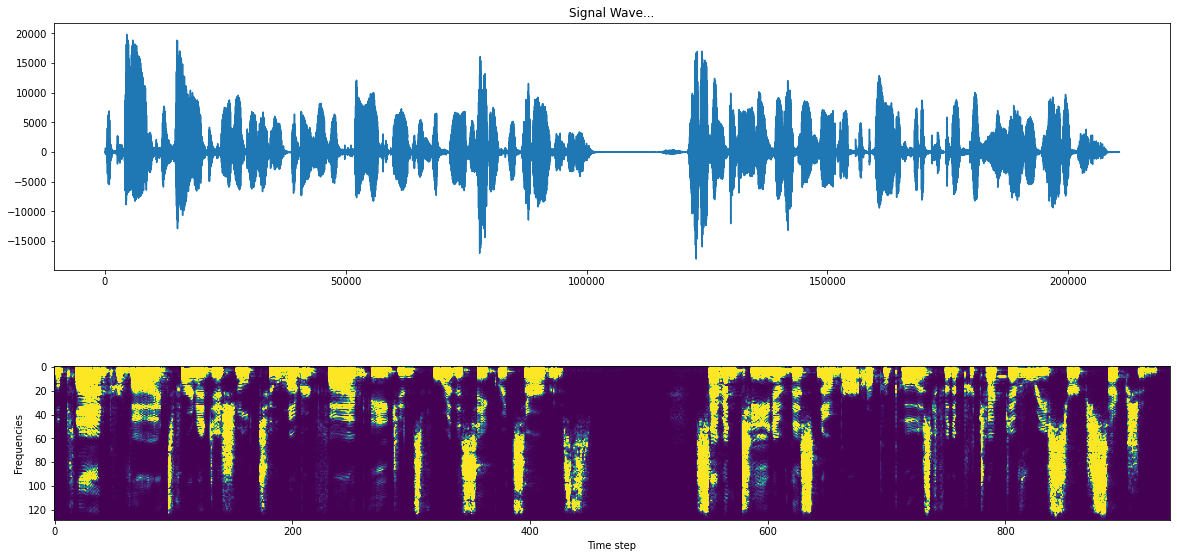

--------------------------------------------------


In [ ]:
print("File name: LJ050-0223.wav")
print(f"Transcription: '{df[df[0] == 'LJ050-0223'][1].values[0]}'")
visualisation(folder + 'LJ050-0223.wav')
print('-'*50)

In [ ]:
sample_rate, samples = wavfile.read(folder + 'LJ050-0223.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate, nperseg=nperseg)
spectrogram = np.transpose(spectrogram)
pearson_correlations = []
eucledian_distances = []
cosine_similarities = []
with tqdm(total=len(spectrogram)) as pbar:
    for i in range(len(spectrogram)):
        a1 = spectrogram[i]
        corr = []
        euc = []
        cos = []
        for j in range(len(spectrogram)):
            a2 = spectrogram[j]    
            corr.append( stats.pearsonr(a1,a2)[0])
            euc.append(distance.euclidean(a1,a2))
            cos.append(1-distance.cosine(a1,a2))
        pearson_correlations.append(corr)
        eucledian_distances.append(euc)
        cosine_similarities.append(cos)
        pbar.update(1)


100%|██████████| 939/939 [03:22<00:00,  4.63it/s]


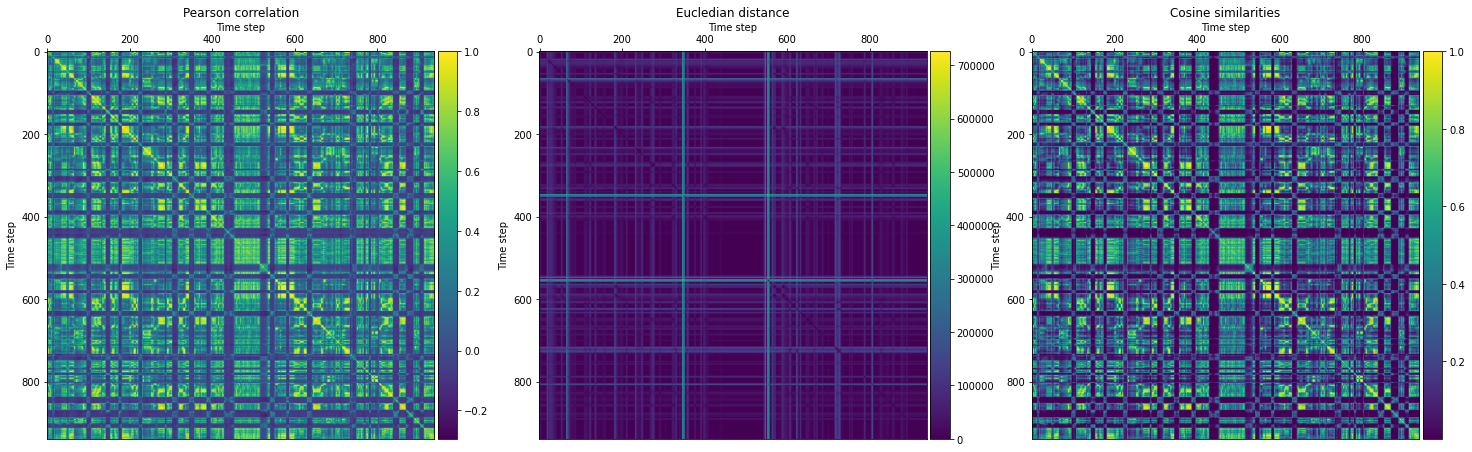

In [ ]:
fig = plt.figure(figsize=(25,10))

ax1 = plt.subplot(1, 3, 1)
im1 = ax1.imshow(pearson_correlations)
plt.title('Pearson correlation')
plt.xlabel('Time step')
plt.ylabel('Time step')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax = cax)
ax1.xaxis.set_label_position('top')
ax1.xaxis.set_ticks_position('top')

ax2 = plt.subplot(1, 3, 2)
im2 = ax2.imshow(eucledian_distances)
plt.title('Eucledian distance')
plt.xlabel('Time step')
plt.ylabel('Time step')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax = cax)
ax2.xaxis.set_label_position('top')
ax2.xaxis.set_ticks_position('top')

ax3 = plt.subplot(1, 3, 3)
im3 =ax3.imshow(cosine_similarities)
plt.title('Cosine similarities')
plt.xlabel('Time step')
plt.ylabel('Time step')
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im3, cax = cax)
ax3.xaxis.set_label_position('top')
ax3.xaxis.set_ticks_position('top')

plt.show()


In [ ]:
# The methods below are used for processing text.
vocabulary_to_index = {'_':0}
index_to_vocabulary = {0:'_'}
for c in range(ord('a'), ord('z')+1):
        vocabulary_to_index[chr(c)] = len(vocabulary_to_index)
        index_to_vocabulary[len(index_to_vocabulary)] = chr(c)

def prepreocess_text(text):
    text = text.lower().replace(" ", "_")    
    out_text = ''
    out_indexes = []
    for c in text:
        last = ''
        if len(out_text) != 0:
            last = out_text[-1]        
        if c in vocabulary_to_index and last!= c:
            out_text += c
            out_indexes.append(vocabulary_to_index[c])
    return out_text, out_indexes

def get_labels_baseline(time_len, clusters):
    labels = []
    w = int(time_len / len(clusters)) 
    for c in clusters:
        labels = labels + [c] * int(w)
    while len(labels) < time_len:
        labels.append(labels[-1])
    return labels[0:time_len], w
    
    

In [ ]:
text = 'would take approximately twenty months to implement and require expenditures of approximately three million dollars during that period.'
print(text)
print(prepreocess_text(text)[0])
print(prepreocess_text(text)[1])
print('Number of clusters is: ', len(prepreocess_text(text)[1]))

would take approximately twenty months to implement and require expenditures of approximately three million dollars during that period.
would_take_aproximately_twenty_months_to_implement_and_require_expenditures_of_aproximately_thre_milion_dolars_during_that_period
[23, 15, 21, 12, 4, 0, 20, 1, 11, 5, 0, 1, 16, 18, 15, 24, 9, 13, 1, 20, 5, 12, 25, 0, 20, 23, 5, 14, 20, 25, 0, 13, 15, 14, 20, 8, 19, 0, 20, 15, 0, 9, 13, 16, 12, 5, 13, 5, 14, 20, 0, 1, 14, 4, 0, 18, 5, 17, 21, 9, 18, 5, 0, 5, 24, 16, 5, 14, 4, 9, 20, 21, 18, 5, 19, 0, 15, 6, 0, 1, 16, 18, 15, 24, 9, 13, 1, 20, 5, 12, 25, 0, 20, 8, 18, 5, 0, 13, 9, 12, 9, 15, 14, 0, 4, 15, 12, 1, 18, 19, 0, 4, 21, 18, 9, 14, 7, 0, 20, 8, 1, 20, 0, 16, 5, 18, 9, 15, 4]
Number of clusters is:  129


# Building training data

In [ ]:
# The methods below are used for processing text.
vocabulary_to_index = {' ':0}
index_to_vocabulary = {0:' '}
for c in range(ord('a'), ord('z')+1):
        vocabulary_to_index[chr(c)] = len(vocabulary_to_index)
        index_to_vocabulary[len(index_to_vocabulary)] = chr(c)

def prepreocess_text(text):
    text = text.lower()
    out_text = ''
    out_indexes = []
    for c in text:
        last = ''
        if len(out_text) != 0:
            last = out_text[-1]        
        if c in vocabulary_to_index and last!= c:
            out_text += c
            out_indexes.append(vocabulary_to_index[c])
    return out_text, out_indexes

def get_labels_baseline(time_len, clusters):
    labels = []
    w = int(time_len / len(clusters)) 
    for c in clusters:
        labels = labels + [c] * int(w)
    while len(labels) < time_len:
        labels.append(labels[-1])
    return labels[0:time_len], w

In [ ]:
df = pd.read_csv('LJSpeech-1.1/metadata.csv', sep='|', header=None)

X = []
y = []

with tqdm(total=len(df)) as pbar:
    for index, row in df.iterrows():
        wave_file = 'LJSpeech-1.1/wavs/'+row[0]+'.wav'
        transcript = row[2]
        sample_rate, samples = wavfile.read(wave_file)
        frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate, nperseg=nperseg)
        spectrogram = np.transpose(spectrogram)
        out_indexes = prepreocess_text(transcript)[1]
        labels_baseline = get_labels_baseline(len(times), out_indexes)[0]
        
        X.append(spectrogram)
        y.append(labels_baseline)

        pbar.update(1)
        
del df

100%|██████████| 13100/13100 [01:20<00:00, 162.08it/s]


In [ ]:
def pad_sequences(sequences, maxlen):
    if isinstance(sequences[0][0], np.ndarray):
        pad_vec = [0]*len(sequences[0][0])
    else:
        pad_vec = 0
    pad_sequences = []
    with tqdm(total=len(sequences)) as pbar:
        for seq in sequences:
            seq = list(seq)
            if len(seq) > maxlen:
                seq = seq[0:maxlen]
            else:
                while len(seq) < maxlen:                
                    seq.insert(0, pad_vec)
            pad_sequences.append(seq)
            pbar.update(1)
    return np.array(pad_sequences)

X = pad_sequences(X, maxlen)
y = pad_sequences(y, maxlen)

X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

100%|██████████| 13100/13100 [00:00<00:00, 166943.31it/s]


In [ ]:
train_len = int(len(X)*0.7)
train_shape = X[:train_len].shape
print(f"The shape of the train set: {train_shape}")
print(f"The the number of sample: {train_shape[0]}")
print(f"The the number of time step: {train_shape[1]}")
print(f"The the number of features per a step: {train_shape[2]}")
print("-"*50)
test_shape = X[train_len:].shape
print(f"The shape of the train set: {test_shape}")
print(f"The the number of sample: {test_shape[0]}")
print(f"The the number of time step: {test_shape[1]}")
print(f"The the number of features per a step: {test_shape[2]}")
print("-"*50)
y_train_shape = y[:train_len].shape
print(f"The shape of the label y: {y_train_shape}")
print(f"The the number of time step: {test_shape[1]}")
vocal_size = len(vocabulary_to_index)
print(f"The the number of features of label : {vocal_size}")
print("-"*50)

The shape of the train set: (9170, 100, 129)
The the number of sample: 9170
The the number of time step: 100
The the number of features per a step: 129
--------------------------------------------------
The shape of the train set: (3930, 100, 129)
The the number of sample: 3930
The the number of time step: 100
The the number of features per a step: 129
--------------------------------------------------
The shape of the label y: (9170, 100)
The the number of time step: 100
The the number of features of label : 27
--------------------------------------------------


# Basic LSTM model


In [ ]:
def create_model(dropout_value,learning_rate):
    model = Sequential()
    model.add(InputLayer(input_shape=(maxlen, train_shape[2])))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(LSTM(256, return_sequences=True))
    # model.add(LSTM(256, return_sequences=True))
    # model.add(LSTM(256, return_sequences=True))
    # model.add(LSTM(256, return_sequences=True))
    model.add(Dense(len(vocabulary_to_index), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=RMSprop(learning_rate=learning_rate), 
                  metrics=['accuracy'])
    return model
    
# #Print details of the model.

model_1 = create_model(0,0.001)
model_1.summary()
# plot_model(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100, 512)          790528    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 512)          1574912   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 256)          787456    
_________________________________________________________________
dense (Dense)                (None, 100, 27)           6939      
Total params: 3,159,835
Trainable params: 3,159,835
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class Test(keras.callbacks.Callback):
  def __init__(self, x_eval, y_eval):
    self.x_eval = x_eval
    self.y_eval = y_eval

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5 == 0:
      i = randrange(len(self.x_eval))
      pred = self.model.predict(np.array([self.x_eval[i]]))
      pred = np.argmax(pred[0],axis=1)
      print('-'*20)
      text = '_'
      for v in self.y_eval[i]:
        if index_to_vocabulary[v] != text[-1]:
          text += index_to_vocabulary[v]
      print(text)
      text = '_'
      for v in pred:
        if index_to_vocabulary[v] != text[-1]:
          text += index_to_vocabulary[v]
      print(text)



In [ ]:
test1 = Test(X[:train_len], y[:train_len])
test2 = Test(X[train_len:], y[train_len:])


history_1= model_1.fit(X[:train_len], 
                    y[:train_len],
                    validation_data=(X[train_len:], y[train_len:]),
                    epochs=no_epochs, 
                    batch_size=bs, 
                    verbose=1,
                    callbacks=[test1, test2])

Epoch 1/30
36/36 [==============================] - 31s 506ms/step - loss: 2.8307 - accuracy: 0.1652 - val_loss: 2.7273 - val_accuracy: 0.1862
--------------------
_there are after a
_te 
--------------------
_wasnt the day
_ta s e
Epoch 2/30
36/36 [==============================] - 16s 453ms/step - loss: 2.6564 - accuracy: 0.1962 - val_loss: 2.6365 - val_accuracy: 0.2039
Epoch 3/30
36/36 [==============================] - 16s 460ms/step - loss: 2.5605 - accuracy: 0.2195 - val_loss: 2.5821 - val_accuracy: 0.2157
Epoch 4/30
36/36 [==============================] - 17s 464ms/step - loss: 2.4793 - accuracy: 0.2384 - val_loss: 2.5347 - val_accuracy: 0.2224
Epoch 5/30
36/36 [==============================] - 17s 462ms/step - loss: 2.4103 - accuracy: 0.2527 - val_loss: 2.4932 - val_accuracy: 0.2339
Epoch 6/30
36/36 [==============================] - 17s 462ms/step - loss: 2.3534 - accuracy: 0.2663 - val_loss: 2.4777 - val_accuracy: 0.2244
--------------------
_was a blind man n
_was br e e
-

In [ ]:
def plot_performance(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(15,4))

  ax1 = plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  ax2 = plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, label='Training accuracy')
  plt.plot(epochs, val_acc, label='Validation accuracy')
  plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()


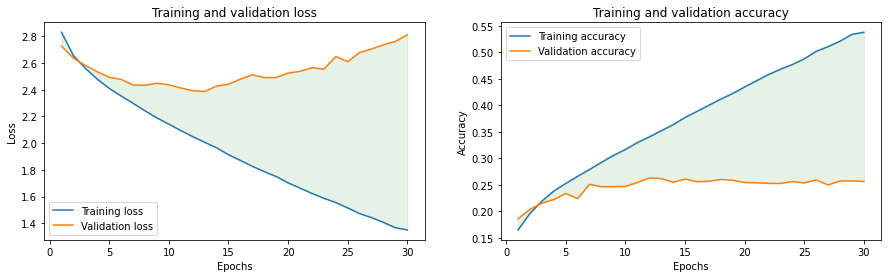

In [ ]:
plot_performance(history_1)

In [ ]:
def test(model):
  i = randrange(len(X[train_len:]))
  pred = model.predict(np.array([X[train_len:][i]]))
  pred = np.argmax(pred[0],axis=1)
  print('-'*20)
  text = '_'
  for v in y[train_len:][i]:
    if index_to_vocabulary[v] != text[-1]:
      text += index_to_vocabulary[v]
  print(text)
  text = '_'
  for v in pred:
    if index_to_vocabulary[v] != text[-1]:
      text += index_to_vocabulary[v]
  print(text)

test(model_1)

--------------------
_in the event of
_in tho vt tfofofhe


# Basic encoder-decoder architecture (Without Attention)

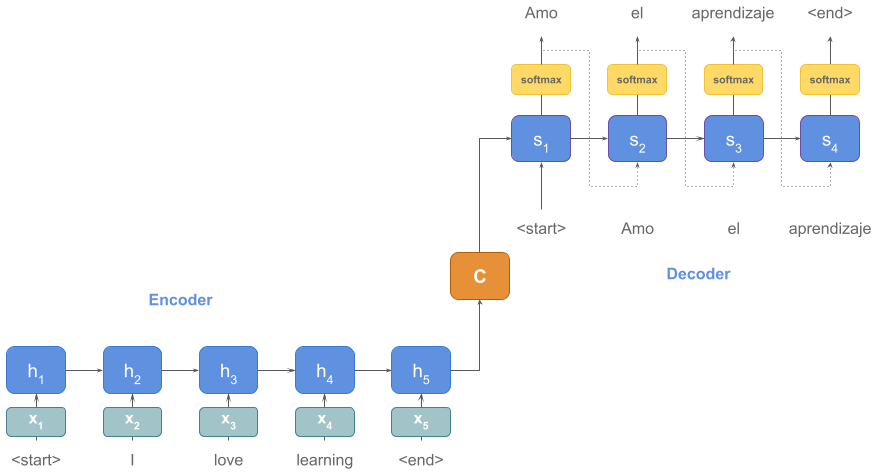

In [ ]:
from keras.layers import Lambda
from keras import backend as K
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Input, Convolution1D, Dot, Activation, Concatenate
from tensorflow.keras import Model

In [ ]:
num_encoder_tokens = train_shape[2]
latent_dim = hidden_dim
num_decoder_tokens = vocal_size
max_decoder_seq_length = maxlen

In [ ]:

def basic_encoder_decoder(latent_dim):
  # Encoder
  encoder_inputs = Input(shape=(None, num_encoder_tokens))
  encoder = LSTM(latent_dim, return_state=True)
  encoder_outputs, state_h, state_c = encoder(encoder_inputs)
  states = [state_h, state_c]

  #Decoder
  decoder_inputs = Input(shape=(1, num_decoder_tokens))
  decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
  decoder_dense = Dense(num_decoder_tokens, activation='softmax')
  all_outputs = []
  inputs = decoder_inputs
  for _ in range(max_decoder_seq_length):
      # Run the decoder on one timestep
      outputs, state_h, state_c = decoder_lstm(inputs,
                                              initial_state=states)
      outputs = decoder_dense(outputs)
      # Store the current prediction (we will concatenate all predictions later)
      all_outputs.append(outputs)
      # Reinject the outputs as inputs for the next loop iteration
      # as well as update the states
      inputs = outputs
      states = [state_h, state_c]
  # Concatenate all predictions
  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  # Define and compile model as previously
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [2]:
#model_5 = basic_encoder_decoder(latent_dim)
#model_5.summary()

In [ ]:
#Create a decoder input to start the decoder
decoder_input_data_train = np.zeros((train_len, 1, num_decoder_tokens))
print(f"The shape of decoder_input_data_train: {decoder_input_data_train.shape}")

decoder_input_data_val = np.zeros((len(X) -train_len, 1, num_decoder_tokens))
print(f"The shape of decoder_input_data_val: {decoder_input_data_val.shape}")


#One hot ecoding tagert
y_onehot = tf.one_hot(y, num_decoder_tokens)
print(f"The shape of y_onehot: {y_onehot.shape}")


The shape of decoder_input_data_train: (9170, 1, 27)
The shape of decoder_input_data_val: (3930, 1, 27)
The shape of y_onehot: (13100, 100, 27)


In [ ]:
 class Test(keras.callbacks.Callback):
  def __init__(self, x_eval, y_eval):
    self.x_eval = x_eval
    self.y_eval = y_eval

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5 == 0:
      decoder_inputs = np.zeros((2, 1, num_decoder_tokens))
      i = randrange(len(self.x_eval)-2)
      pred = self.model.predict([self.x_eval[i:i+2], decoder_inputs])[0]
      pred = np.argmax(pred,axis=1)
      print('-'*20)
      text = '_'
      for v in self.y_eval[i]:
        if index_to_vocabulary[v] != text[-1]:
          text += index_to_vocabulary[v]
      print(text)
      text = '_'
      for v in pred:
        if index_to_vocabulary[v] != text[-1]:
          text += index_to_vocabulary[v]
      print(text)

test1 = Test(X[:train_len], y[:train_len])
test2 = Test(X[train_len:], y[train_len:])

In [ ]:
history_5 = model_5.fit([X[:train_len], decoder_input_data_train], y_onehot[:train_len],
            batch_size=bs,
            epochs=no_epochs,
            validation_data=([X[train_len:], decoder_input_data_val], y_onehot[train_len:]),
            callbacks=[test1, test2])

Epoch 1/30
36/36 [==============================] - 221s 2s/step - loss: 2.9357 - accuracy: 0.1666 - val_loss: 2.8313 - val_accuracy: 0.1699
--------------------
_having ben comite
_t 
--------------------
_and a total m
_tnthe 
Epoch 2/30
36/36 [==============================] - 12s 328ms/step - loss: 2.8091 - accuracy: 0.1846 - val_loss: 2.8134 - val_accuracy: 0.1772
Epoch 3/30
36/36 [==============================] - 12s 322ms/step - loss: 2.7927 - accuracy: 0.1887 - val_loss: 2.8103 - val_accuracy: 0.1781
Epoch 4/30
36/36 [==============================] - 12s 330ms/step - loss: 2.7857 - accuracy: 0.1899 - val_loss: 2.8062 - val_accuracy: 0.1786
Epoch 5/30
36/36 [==============================] - 12s 325ms/step - loss: 2.7811 - accuracy: 0.1905 - val_loss: 2.8038 - val_accuracy: 0.1779
Epoch 6/30
36/36 [==============================] - 12s 327ms/step - loss: 2.7782 - accuracy: 0.1909 - val_loss: 2.8084 - val_accuracy: 0.1787
--------------------
_but it was long befo
_the 
-------

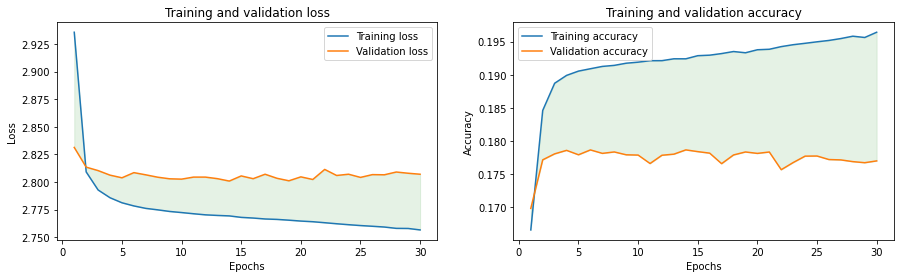

In [ ]:
plot_performance(history_5)

# Multiple layers for encoder decoder.ipynb

In [ ]:
from keras.layers import Lambda
from keras import backend as K
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Input, Convolution1D, Dot, Activation, Concatenate
from tensorflow.keras import Model

In [ ]:
num_encoder_tokens = train_shape[2]
latent_dim = hidden_dim
num_decoder_tokens = vocal_size
max_decoder_seq_length = maxlen

In [ ]:
def create_model(latent_dim):
  # Encoder
  encoder_inputs = Input(shape=(None, num_encoder_tokens))
  encoder = LSTM(latent_dim,return_state=True,return_sequences=True)(encoder_inputs)
  encoder = LSTM(latent_dim,return_state=True,return_sequences=True)(encoder)
  encoder = LSTM(latent_dim,return_state=True)(encoder)

  encoder_outputs, state_h, state_c = encoder
  states = [state_h, state_c]

  #Decoder
  decoder_inputs = Input(shape=(1, num_decoder_tokens))

  all_outputs = []
  inputs = decoder_inputs
  for _ in range(max_decoder_seq_length):
      # Run the decoder on one timestep
      decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)(decoder_inputs, initial_state=states)
      decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)(decoder_lstm)
      outputs, state_h, state_c = decoder_lstm
      decoder_dense = Dense(num_decoder_tokens, activation='softmax')
      
      outputs = decoder_dense(outputs)
      # Store the current prediction (we will concatenate all predictions later)
      all_outputs.append(outputs)
      # Reinject the outputs as inputs for the next loop iteration
      # as well as update the states
      inputs = outputs
      states = [state_h, state_c]
  # Concatenate all predictions
  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  # Define and compile model as previously
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
use_tpu = True
if use_tpu:
    print("Use TPU")
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model_5 = create_model(latent_dim)
else:
    print("Dont use TPU")
    model_5 = create_model(latent_dim)

Use TPU
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.44.43.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.44.43.234:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
#model_5.summary()

In [ ]:
   #Create a decoder input to start the decoder
decoder_input_data_train = np.zeros((train_len, 1, num_decoder_tokens))
print(f"The shape of decoder_input_data_train: {decoder_input_data_train.shape}")

decoder_input_data_val = np.zeros((len(X) -train_len, 1, num_decoder_tokens))
print(f"The shape of decoder_input_data_val: {decoder_input_data_val.shape}")


#One hot ecoding tagert
y_onehot = tf.one_hot(y, num_decoder_tokens)
print(f"The shape of y_onehot: {y_onehot.shape}")


The shape of decoder_input_data_train: (9170, 1, 27)
The shape of decoder_input_data_val: (3930, 1, 27)
The shape of y_onehot: (13100, 100, 27)


In [ ]:
 class Test(keras.callbacks.Callback):
  def __init__(self, x_eval, y_eval):
    self.x_eval = x_eval
    self.y_eval = y_eval

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5 == 0:
      decoder_inputs = np.zeros((2, 1, num_decoder_tokens))
      i = randrange(len(self.x_eval)-2)
      pred = self.model.predict([self.x_eval[i:i+2], decoder_inputs])[0]
      pred = np.argmax(pred,axis=1)
      print('-'*20)
      text = '_'
      for v in self.y_eval[i]:
        if index_to_vocabulary[v] != text[-1]:
          text += index_to_vocabulary[v]
      print(text)
      text = '_'
      for v in pred:
        if index_to_vocabulary[v] != text[-1]:
          text += index_to_vocabulary[v]
      print(text)

test1 = Test(X[:train_len], y[:train_len])
test2 = Test(X[train_len:], y[train_len:])

In [ ]:
history_5 = model_5.fit([X[:train_len], decoder_input_data_train ], y_onehot[:train_len],
            batch_size=bs,
            epochs=no_epochs,
            validation_data=([X[train_len:], decoder_input_data_val], y_onehot[train_len:]),
            callbacks=[test1, test2])

Epoch 1/100
 6/36 [====>.........................] - ETA: 7s - loss: 3.5436 - accuracy: 0.1616WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0094s vs `on_train_batch_end` time: 39.7305s). Check your callbacks.


36/36 [==============================] - 863s 12s/step - loss: 2.9529 - accuracy: 0.1751 - val_loss: 2.8225 - val_accuracy: 0.1705
--------------------
_was_a_piece_of_a_
_the_e_e_e_e_e_ea_e_e_e_e_
--------------------
_however_pursuant_
_the_e_e_e_e_e_ea_e_e_e_e_
Epoch 2/100
36/36 [==============================] - 10s 278ms/step - loss: 2.7912 - accuracy: 0.1870 - val_loss: 2.8098 - val_accuracy: 0.1792
Epoch 3/100
36/36 [==============================] - 10s 278ms/step - loss: 2.7937 - accuracy: 0.1894 - val_loss: 2.8061 - val_accuracy: 0.1789
Epoch 4/100
36/36 [==============================] - 10s 279ms/step - loss: 2.7784 - accuracy: 0.1906 - val_loss: 2.8083 - val_accuracy: 0.1785
Epoch 5/100
36/36 [==============================] - 10s 279ms/step - loss: 2.7766 - accuracy: 0.1910 - val_loss: 2.8075 - val_accuracy: 0.1751
Epoch 6/100
36/36 [==============================] - 10s 279ms/step - loss: 2.7740 - accuracy: 0.1918 - val_loss: 2.8053 - val_accuracy: 0.1752
---------------

In [ ]:
def plot_performance(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(15,4))

  ax1 = plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  ax2 = plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, label='Training accuracy')
  plt.plot(epochs, val_acc, label='Validation accuracy')
  plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

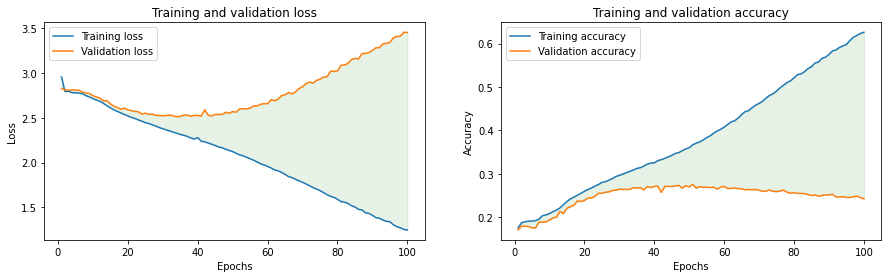

In [ ]:
plot_performance(history_5)

# Attention Machine

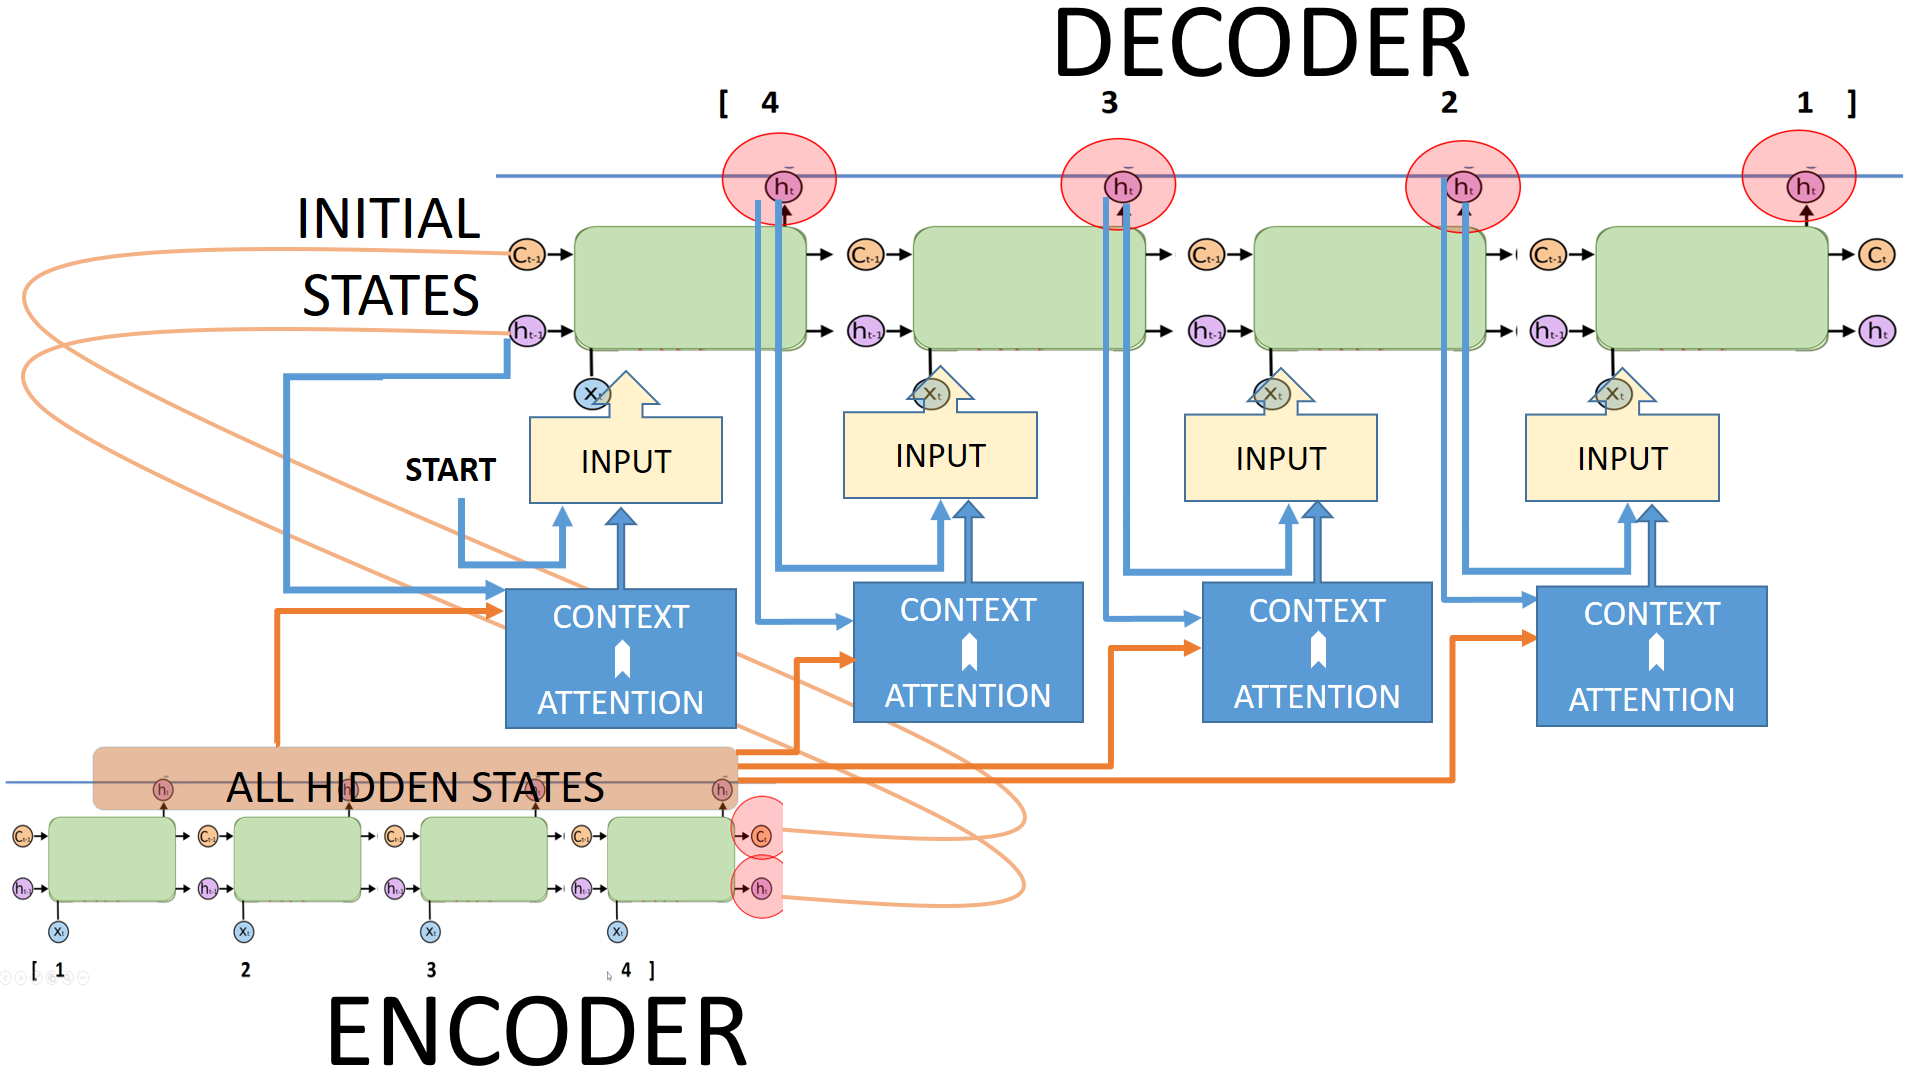

In [ ]:
def generate_text(indexes, no_epochs):
  indexes =  tf.argmax(indexes, axis=2)
  texts = []
  for index in indexes.numpy():
    text = '_'
    for v in index:
        if index_to_vocabulary[v] != text[-1]:
          text += index_to_vocabulary[v]
    texts.append(text[1:].replace("_", " "))
  return texts

def word_error_rate(y_true, y_pred):

  y_true = generate_text(y_true, len(y_true))
  y_pred = generate_text(y_pred, len(y_pred))

  wer_score = wer(y_true,y_pred)
  if  int(len(y_true)) == 64:
    list_wer_trainning.append(wer_score)
  else:
    list_wer_val.append(wer_score)
  return wer_score

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, InputLayer, Input, Lambda, RepeatVector, Concatenate
from tensorflow.keras import Model

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

In [ ]:
def create_model():
  encoder_inputs = Input(shape=(enc_max_len, enc_features), name='encoder_inputs')
  encoder_lstm = LSTM(hidden_dim,return_sequences=True, return_state=True,  name='encoder_lstm')
  encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

  print(f'Encoder input shape: (batch size, enc_max_len, enc_features):    {encoder_inputs.shape}')
  print(f'Encoder output shape: (batch size, enc_max_len, hidden_dim):    {encoder_outputs.shape}')
  print(f'Encoder encoder_states_h shape: (batch size, hidden_dim):       {encoder_state_h.shape}')
  print(f'Encoder encoder_states_c shape: (batch size, hidden_dim):       {encoder_state_c.shape}')

  encoder_states = [encoder_state_h, encoder_state_c]
  print(f"Encoder encoder_states:   {encoder_states}")

  # Set up the attention layer
  attention= BahdanauAttention(512)

  # Set up the decoder layers
  decoder_lstm = LSTM(hidden_dim,  return_state=True, name='decoder_lstm')
  decoder_dense = Dense(dec_features, activation='softmax',  name='decoder_dense')

  all_outputs = []
  inputs = np.zeros((batch_size, 1, dec_features), dtype = "float32")
  inputs[:, 0, 0] = 1 
  print(f'Inputs shape for DECODER part: (batch size, enc_max_len, dec_num_feature): {inputs.shape}')
  decoder_outputs = encoder_state_h
  states = encoder_states
  view_shape = True
  # decoder will only process one time step at a time.
  for _ in range(dec_max_len):

      context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)
      if view_shape:
        print("-"*65)
        print("Attention context_vector: (batch size, units) {}".format(context_vector.shape))
        print("Attention weights : (batch_size, dec_max_len, 1) {}".format(attention_weights.shape))
        print("decoder_outputs: (batch_size,  hidden_dim) {}".format(decoder_outputs.shape))
      context_vector = tf.expand_dims(context_vector, 1)

      if view_shape:
        print("-"*65)
        print("Attention context_vector (after expand): (batch size, 1, units) {}".format(context_vector.shape))
      inputs = tf.concat([context_vector, inputs], axis=-1)

      if view_shape:
        print("-"*65)
        print(f"After concat inputs: (batch_size, 1, n_features + hidden_size): {inputs.shape}" )
      decoder_outputs, decoder_state_h, decoders_state_c = decoder_lstm(inputs, initial_state=states)

      if view_shape:
        print("-"*65)
        print(f'Decoder output shape: (batch size, enc_max_len, hidden_dim): {decoder_outputs.shape}')
        print(f'decoder_state_h shape: (batch size, hidden_dim):  {decoder_state_h.shape}')
        print(f'decoders_state_c shape: (batch size, hidden_dim): { decoders_state_c.shape}')

      outputs = decoder_dense(decoder_outputs)
      if view_shape:
        print("-"*65)
        print(f"outputs shape: (batch size, hidden_dim): {outputs.shape}")

      outputs = tf.expand_dims(outputs, 1)
      if view_shape:
        print("-"*65)
        print(f"outputs shape (After exapnd): (batch size, 1, hidden_dim): {outputs.shape}")

      all_outputs.append(outputs)
      inputs = outputs
      states = [decoder_state_h,decoders_state_c]
      view_shape = False

  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  model = Model(encoder_inputs, decoder_outputs)
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=["accuracy", word_error_rate])
  return model

In [ ]:
 #resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
use_tpu = False
if use_tpu:
    print("Use TPU")
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model()
else:
    print("Dont use TPU")
    model = create_model()

Dont use TPU
Encoder input shape: (batch size, enc_max_len, enc_features):    (None, 100, 129)
Encoder output shape: (batch size, enc_max_len, hidden_dim):    (None, 100, 64)
Encoder encoder_states_h shape: (batch size, hidden_dim):       (None, 64)
Encoder encoder_states_c shape: (batch size, hidden_dim):       (None, 64)
Encoder encoder_states:   [<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'encoder_lstm')>, <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'encoder_lstm')>]
Inputs shape for DECODER part: (batch size, enc_max_len, dec_num_feature): (64, 1, 27)
-----------------------------------------------------------------
Attention context_vector: (batch size, units) (None, 64)
Attention weights : (batch_size, dec_max_len, 1) (None, 100, 1)
decoder_outputs: (batch_size,  hidden_dim) (None, 64)
-----------------------------------------------------------------
Attention context_vector (after expand): (batch size, 1, units) (None, 1, 64)
--------------

In [ ]:
history = model.fit(X[:len_train], y_onehot[:len_train], 
                      batch_size= batch_size,
                      validation_data=(X[len_train:len_val], y_onehot[len_train:len_val]),
                      epochs = 100)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
160/160 [==============================] - 570s 4s/step - loss: 2.8158 - accuracy: 0.1785 - word_error_rate: 0.9302 - val_loss: 2.7862 - val_accuracy: 0.1784 - val_word_error_rate: 0.9287
Epoch 2/100
160/160 [==============================] - 561s 4s/step - loss: 2.7658 - accuracy: 0.1883 - word_error_rate: 0.9085 - val_loss: 2.7737 - val_accuracy: 0.1793 - val_word_error_rate: 0.9276
Epoch 3/100
160/160 [==============================] - 556s 3s/step - loss: 2.7486 - accuracy: 0.1908 - word_error_rate: 0.9074 - val_loss: 2.7568 - val_accuracy: 0.1797 - val_word_error_rate: 0.9246
Epoch 4/100
160/160 [==============================] - 560s 4s/step - loss: 2.7306 - accuracy: 0.1946 - word_error_rate: 0.9052 - val_loss: 2.7478 - val_accuracy: 0.1854 - val_word_error_rate: 0.9251
Epoch 5/100
160/160 [==============================] - 558s 3s/step - loss: 2.7074 - accuracy: 0.2004 - word_error_rate: 0.9020 - val_loss: 2.7140 - val_accuracy: 0.1942 - val_word_error_rate: 0.9134


# New algorithm

In [7]:
import os
import random
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LSTM,Bidirectional,Input,Concatenate, Dense, Lambda, Embedding
from keras.models import Model
import numpy as np
import keras.backend as K

In [8]:
keras.utils.get_file(
    os.path.join(os.getcwd(), "data.tar.gz"),
    "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2",
    extract=True,
    archive_format="tar",
    cache_dir=".",
)

2748588032/2748572632 [==============================] - 39s 0us/step


'/content/data.tar.gz'

In [9]:
saveto = "./datasets/LJSpeech-1.1"
wavs = glob("{}/**/*.wav".format(saveto), recursive=True)

id_to_text = {}
with open(os.path.join(saveto, "metadata.csv"), encoding="utf-8") as f:
    for line in f:
        id = line.strip().split("|")[0]
        text = line.strip().split("|")[2]
        id_to_text[id] = text


def get_data(wavs, id_to_text, maxlen=50):
    """ returns mapping of audio paths and transcription texts """
    data = []
    for w in wavs:
        id = w.split("/")[-1].split(".")[0]
        if len(id_to_text[id]) < maxlen:
            data.append({"audio": w, "text": id_to_text[id]})
    return data

In [13]:
bs = 32

In [14]:
class VectorizeChar:
    def __init__(self, max_len=50):
        self.vocab = (
            ["-", "#", "<", ">"]
            + [chr(i + 96) for i in range(1, 27)]
            + [" ", ".", ",", "?"]
        )
        self.max_len = max_len
        self.char_to_idx = {}
        for i, ch in enumerate(self.vocab):
            self.char_to_idx[ch] = i

    def __call__(self, text):
        text = text.lower()
        text = text[: self.max_len - 2]
        text = "<" + text + ">"
        pad_len = self.max_len - len(text)
        return [self.char_to_idx.get(ch, 1) for ch in text] + [0] * pad_len

    def get_vocabulary(self):
        return self.vocab


max_target_len = 100  # all transcripts in out data are < 200 characters
data = get_data(wavs, id_to_text, max_target_len)
vectorizer = VectorizeChar(max_target_len)
print("vocab size", len(vectorizer.get_vocabulary()))


def create_text_ds(data):
    texts = [_["text"] for _ in data]
    text_ds = [vectorizer(t) for t in texts]
    text_ds = tf.one_hot(text_ds, len(vectorizer.get_vocabulary()))
    text_ds = tf.data.Dataset.from_tensor_slices(text_ds)
    return text_ds


def path_to_audio(path):
    # spectrogram using stft
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1)
    audio = tf.squeeze(audio, axis=-1)
    stfts = tf.signal.stft(audio, frame_length=200, frame_step=80, fft_length=256)
    x = tf.math.pow(tf.abs(stfts), 0.5)
    # normalisation
    means = tf.math.reduce_mean(x, 1, keepdims=True)
    stddevs = tf.math.reduce_std(x, 1, keepdims=True)
    x = (x - means) / stddevs
    audio_len = tf.shape(x)[0]
    # padding to 10 seconds
    pad_len = 2754
    paddings = tf.constant([[0, pad_len], [0, 0]])
    x = tf.pad(x, paddings, "CONSTANT")[:pad_len, :]
    return x


def create_audio_ds(data):
    flist = [_["audio"] for _ in data]
    audio_ds = tf.data.Dataset.from_tensor_slices(flist)
    audio_ds = audio_ds.map(
        path_to_audio, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    return audio_ds


def create_tf_dataset(data, bs=4):
    audio_ds = create_audio_ds(data)
    text_ds = create_text_ds(data)
    ds = tf.data.Dataset.zip((audio_ds, text_ds))
    ds = ds.batch(bs)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


split = int(len(data) * 0.8 )
train_data = data[:split]
test_data = data[split:]
ds = create_tf_dataset(train_data, bs=bs).take(153)
val_ds = create_tf_dataset(test_data, bs=bs).take(38)

vocab size 34


In [15]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [16]:
encoder_inputs = Input(shape=(None, 129), name='encoder_inputs')
conv1 = tf.keras.layers.Conv1D(32, 11, strides=2, padding="same", activation="relu")(encoder_inputs)
conv2 = tf.keras.layers.Conv1D(32, 11, strides=2, padding="same", activation="relu")(conv1)
conv3 = tf.keras.layers.Conv1D(32, 11, strides=2, padding="same", activation="relu")(conv2)
encoder_lstm = Bidirectional(LSTM(64,return_sequences=True, return_state=True,  name='encoder_lstm'))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(conv3)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

encoder_states = [state_h, state_c]

# Set up the attention layer
attention= BahdanauAttention(128)

# Set up the decoder layers
decoder_lstm = LSTM(128, return_state=True, name='decoder_lstm')
decoder_dense = Dense(34, activation='softmax',  name='decoder_dense')

all_outputs = []
inputs = np.zeros((bs, 1, 34), dtype = "float32")
inputs[:, 0, 0] = 1 

decoder_outputs = state_h
states = encoder_states
view_shape = True
# decoder will only process one time step at a time.
for _ in range(100):

    context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)
    context_vector = tf.expand_dims(context_vector, 1)

    inputs = tf.concat([context_vector, inputs], axis=-1)
    decoder_outputs, decoder_state_h, decoders_state_c = decoder_lstm(inputs, initial_state=states)
    outputs = decoder_dense(decoder_outputs)

    outputs = tf.expand_dims(outputs, 1)
    all_outputs.append(outputs)
    inputs = outputs
    states = [decoder_state_h,decoders_state_c]
    view_shape = False

decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
model = Model(encoder_inputs, decoder_outputs)

In [17]:
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self,
        init_lr=0.00001,
        lr_after_warmup=0.001,
        final_lr=0.00001,
        warmup_epochs=15,
        decay_epochs=85,
        steps_per_epoch=203,
    ):
        super().__init__()
        self.init_lr = init_lr
        self.lr_after_warmup = lr_after_warmup
        self.final_lr = final_lr
        self.warmup_epochs = warmup_epochs
        self.decay_epochs = decay_epochs
        self.steps_per_epoch = steps_per_epoch

    def calculate_lr(self, epoch):
        """ linear warm up - linear decay """
        warmup_lr = (
            self.init_lr
            + ((self.lr_after_warmup - self.init_lr) / (self.warmup_epochs - 1)) * epoch
        )
        decay_lr = tf.math.maximum(
            self.final_lr,
            self.lr_after_warmup
            - (epoch - self.warmup_epochs)
            * (self.lr_after_warmup - self.final_lr)
            / (self.decay_epochs),
        )
        return tf.math.minimum(warmup_lr, decay_lr)

    def __call__(self, step):
        epoch = step // self.steps_per_epoch
        return self.calculate_lr(epoch)

In [18]:
learning_rate = CustomSchedule(
    init_lr=0.00001,
    lr_after_warmup=0.001,
    final_lr=0.00001,
    warmup_epochs=15,
    decay_epochs=85,
    steps_per_epoch=len(ds),
)

optimizer = keras.optimizers.Adam(learning_rate)

In [19]:
model.compile(optimizer=optimizer, loss ='categorical_crossentropy', metrics=["accuracy"])

In [20]:
history = model.fit(ds, validation_data=val_ds, epochs=100)

Epoch 1/100
153/153 [==============================] - 456s 2s/step - loss: 3.3204 - accuracy: 0.2580 - val_loss: 3.0342 - val_accuracy: 0.2837
Epoch 2/100
153/153 [==============================] - 195s 1s/step - loss: 2.4954 - accuracy: 0.3397 - val_loss: 2.2970 - val_accuracy: 0.3791
Epoch 3/100
153/153 [==============================] - 191s 1s/step - loss: 2.2690 - accuracy: 0.3841 - val_loss: 2.2573 - val_accuracy: 0.3879
Epoch 4/100
153/153 [==============================] - 191s 1s/step - loss: 2.2376 - accuracy: 0.3862 - val_loss: 2.2886 - val_accuracy: 0.3841
Epoch 5/100
153/153 [==============================] - ETA: 0s - loss: 2.2193 - accuracy: 0.3866

KeyboardInterrupt: ignored